> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Before submitting your project, it will be a good idea to go back through your report and remove these sections to make the presentation of your work as tidy as possible. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Investigating "no-shows" in medical appointments in Brazil

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

A big deal of patients (30%) do not attend their medical appoint in Brazil. To find out why so many people miss their appointment, Joni Hoppen and Aquarela Advanced Analytics have provied a dataset with more than 100,000 entries and 14 varialbes. The dataset is free to download from kaggle just follow this [link](https://www.kaggle.com/joniarroba/noshowappointments)

In this report we will be analyzing the above mentioned dataset and finding insights in why people do not attend their medical appointments. We will be working along the following three questions:

* **Question 1:** Does the time between scheduling the appoint and the appoint have an impact in the no-show behaviour of the patients?
* **Question 2:** Are males more likely to miss an appointment? and how do the age-group affect their behaviour? 
* **Question 3:** Are SMS a good way to decrease the no-shows?

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected for analysis. At the end of this section, describe the questions that you plan on exploring over the course of the report. Try to build your report around the analysis of at least one dependent variable and three independent variables.
>
> If you haven't yet selected and downloaded your data, make sure you do that first before coming back here. If you're not sure what questions to ask right now, then make sure you familiarize yourself with the variables and the dataset context for ideas of what to explore.

Let us first do the setup and get all the libraries we will be working with

In [1]:
# import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # just in case we want to make fancy graphics 

%matplotlib inline 

<a id='wrangling'></a>
## Data Wrangling

In this section of the report, we will load the data and check for "cleanliness", and then trim and clean the dataset for our analysis. By the end of this section we will be ready to start the exploratory part!

In [2]:
# load the data - since I saved the data in the same directory, there is no need to change it
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

# make sure the data was loaded properly
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Great! the data seems to be working fine, now let us understand it better

In [3]:
df.shape

(110527, 14)

To make my life easier, I will change all labels to lower case and delete all possible blank spaces:

In [4]:
# first chage all the labels to lowercase and make sure there are no weird spaces. Furthermore lets make all underscored

df.rename(columns = lambda x: x.strip().lower().replace('-','_'), inplace=True)

# check if the changes worked

df.head(1)

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No


In [5]:
df.describe()

,patientid,appointmentid,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


The first statistics about the data give us the first insights:
* The min and the max of the variable Age seem a little bit odd
* Handcap is a true or false statement, so there should not be a max value of "4"
* the "No-show" variable is no numerical value. This column is bit tricky since "Yes" means the patient didn't show to the appointment

In [6]:
# check the age variables to see how many pacients are above 90

df.query('age >= 90')['age'].value_counts(sort=False, ascending=True)

90     109
91      66
92      86
93      53
94      33
95      24
96      17
97      11
98       6
99       1
100      4
102      2
115      5
Name: age, dtype: int64

Patients with the age of 115 are very suspicious, and because they not representative in the dataset I will just drop all their entries

In [7]:
df.drop(df.index[df.age == 115], inplace=True)
df.shape

(110522, 14)

Lets check the handcap column, to see where this "4" value is comming from

In [8]:
df.handcap.value_counts()

0    108285
1      2038
2       183
3        13
4         3
Name: handcap, dtype: int64

since there is only the possibility to be true or false, I will change all values above "1" to "1", meaning true

In [9]:
# replace all the values above one to the value one (true)

df.handcap.replace([2,3,4], 1, inplace=True)

# check that this worked out

df.handcap.value_counts()

0    108285
1      2237
Name: handcap, dtype: int64

Finally change the "no_show" column to numerical values so I can run some regressions on it

In [10]:
# lets take a look of the distribution first

df.no_show.value_counts()

No     88206
Yes    22316
Name: no_show, dtype: int64

In [11]:
# now lets change all "Yes" to "1" meaning True and all "No" to "0" meaning False

df.no_show.replace({"Yes": 1, "No": 0}, inplace=True)

# check this worked out
df.no_show.value_counts()

0    88206
1    22316
Name: no_show, dtype: int64

Awesome! lets see what else we need to change

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110522 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   patientid       110522 non-null  float64
 1   appointmentid   110522 non-null  int64  
 2   gender          110522 non-null  object 
 3   scheduledday    110522 non-null  object 
 4   appointmentday  110522 non-null  object 
 5   age             110522 non-null  int64  
 6   neighbourhood   110522 non-null  object 
 7   scholarship     110522 non-null  int64  
 8   hipertension    110522 non-null  int64  
 9   diabetes        110522 non-null  int64  
 10  alcoholism      110522 non-null  int64  
 11  handcap         110522 non-null  int64  
 12  sms_received    110522 non-null  int64  
 13  no_show         110522 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 12.6+ MB


Some of the columns (variables) are irrelevant for our analysis, so I will drop the patient and appointment ID. Furthermore, since I cannot do much with the neighbourhood, because I do not know if it reflects some kind of socio-economic status, I will drop this column as well

In [13]:
df.drop(columns=['patientid', 'appointmentid', 'neighbourhood'], inplace=True)

Finally I want to change the "gender" variable to a numerical value to see the correlation to the no_show. To make it also easier to understand, I will rename the column to "female" with a binary value: 1 for true and 0 for false

In [14]:
# Check the distribution

df.gender.value_counts()

F    71835
M    38687
Name: gender, dtype: int64

In [15]:
# change the name of the variable

df.rename(columns = {'gender': 'female'}, inplace=True)
df.head(1)

,female,scheduledday,appointmentday,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,0,1,0,0,0,0,0


In [16]:
# change all "F" for 1 and all "M" to 0

df.female.replace({"F": 1, "M": 0}, inplace=True)

# check that all works

df.female.value_counts()

1    71835
0    38687
Name: female, dtype: int64

Furhtermore we will need to change the data type of "scheduledday" and "appointmentday" to dates. So that we can work easier with the values 

In [17]:
# now lets change the data type of the two variables

df.scheduledday = pd.to_datetime(df.scheduledday)
df.appointmentday = pd.to_datetime(df.appointmentday)

# check if this worked

print(df.scheduledday.dtypes)
print(df.appointmentday.dtypes)

datetime64[ns, UTC]
datetime64[ns, UTC]


Finally let's look for duplicates

In [18]:
df.duplicated().sum()

721

**Awesome!** these duplicates are most likely because I deleted the patient und appointment id, so nothing to worry about! This means the data set is "clean" and ready to be explored!

In [19]:
# final look to the the basic metrics

df.describe()

,female,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show
count,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000,110522.000000
mean,0.649961,37.085350,0.098270,0.197246,0.071868,0.030401,0.020240,0.321031,0.201915
std,0.476984,23.104785,0.297681,0.397921,0.258270,0.171689,0.140822,0.466875,0.401431
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,102.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).

### Data Cleaning (Replace this with more specific notes!)

<a id='eda'></a>
## Exploratory Data Analysis

Let us first make some general exploration of the data - the distribution of the variables and their relation to each other

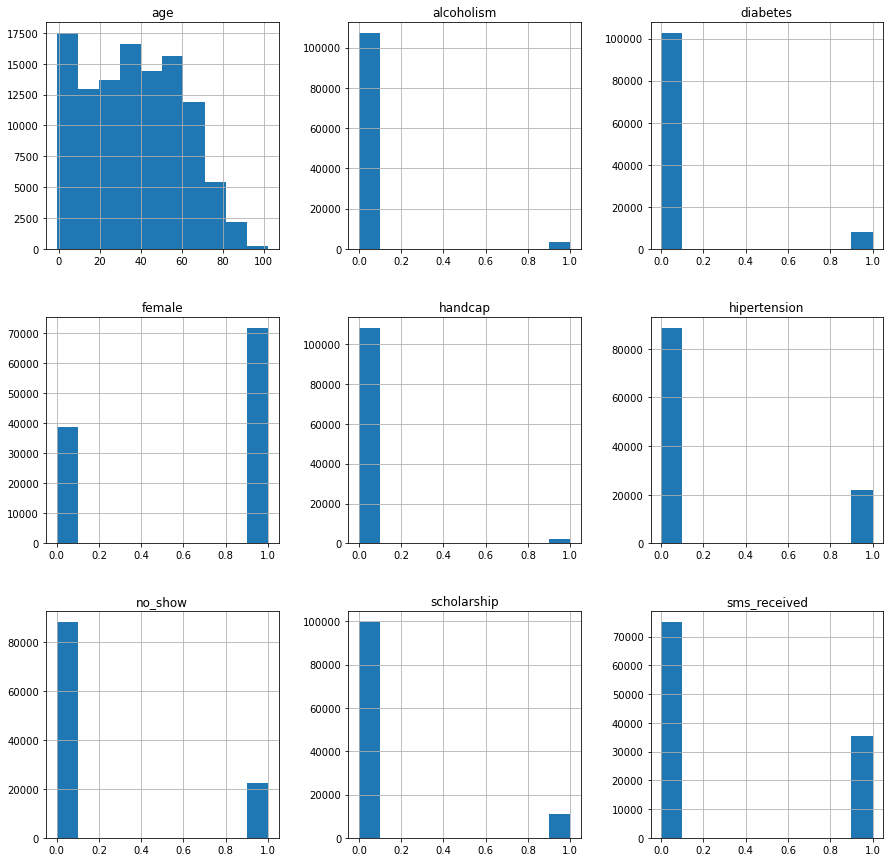

In [20]:
# get a view of the distributions of each variable

df.hist(figsize = (15,15));

In [ ]:
# let's check the correlations as well

pd.plotting.scatter_matrix(df, figsize=(15,15));

As expected the relation between the variables cannot be give by a scatter plot since all variables besides age are binary. Now let us deep into the questions.

Since `no_show` is our dependent variable, I will create a mask, that will make the further analysis much easier

In [47]:
show_mask = df.no_show == 0
no_show_mask = df.no_show == 1

### Research Question 1: Does the time between scheduling the appointment and the appointment have an impact in the no-show behaviour of the patients?

First we need to create a column that contains the information we are looking for: the time in days between scheduling and the appointment

In [22]:
df['time_passed'] = df['appointmentday'] - df['scheduledday'] 
df['time_passed'] = df['time_passed']
df.head(2)

,female,scheduledday,appointmentday,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,time_passed
0,1,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,0,1,0,0,0,0,0,-1 days +05:21:52
1,0,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,0,0,0,0,0,0,0,-1 days +07:51:33


In [23]:
df['time_passed']

0        -1 days +05:21:52
1        -1 days +07:51:33
2        -1 days +07:40:56
3        -1 days +06:30:29
4        -1 days +07:52:37
                ...       
110522    34 days 14:44:25
110523    34 days 16:32:27
110524    40 days 07:56:08
110525    40 days 08:50:37
110526    40 days 10:29:04
Name: time_passed, Length: 110522, dtype: timedelta64[ns]

In [24]:
# for further calculations we need to convert the timestamps to floats
df['time_passed'] = df['time_passed'] / np.timedelta64(1, 'D')
df['time_passed']

0         -0.776481
1         -0.672535
2         -0.679907
3         -0.728831
4         -0.671794
            ...    
110522    34.614178
110523    34.689201
110524    40.330648
110525    40.368484
110526    40.436852
Name: time_passed, Length: 110522, dtype: float64

We can see that there are some neagitve values, that per definition are not allowed. Before we do something with them, we need to understand it better

In [25]:
df.query('time_passed < 0').time_passed.describe()

count    38567.000000
mean        -0.445791
std          0.130287
min         -6.575926
25%         -0.552633
50%         -0.406655
75%         -0.338571
max         -0.256667
Name: time_passed, dtype: float64

There are too many negative values! approx. 40,000 entries! Clearly there must have been some error when recording the dates. Since I have no furhter information, if this error just mean that the patient had their appoint on the same day, I will have to ignore all these entries to answer question 1.

In [27]:
# create a new dataframe without the rows with the negative entries 
df_time = df.copy()
df_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110522 entries, 0 to 110526
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   female          110522 non-null  int64              
 1   scheduledday    110522 non-null  datetime64[ns, UTC]
 2   appointmentday  110522 non-null  datetime64[ns, UTC]
 3   age             110522 non-null  int64              
 4   scholarship     110522 non-null  int64              
 5   hipertension    110522 non-null  int64              
 6   diabetes        110522 non-null  int64              
 7   alcoholism      110522 non-null  int64              
 8   handcap         110522 non-null  int64              
 9   sms_received    110522 non-null  int64              
 10  no_show         110522 non-null  int64              
 11  time_passed     110522 non-null  float64            
dtypes: datetime64[ns, UTC](2), float64(1), int64(9)
memory usage: 11.0 MB


In [32]:
# drop the rows that are not relevant anymore

df_time.drop(df_time.index[df_time.time_passed < 0], inplace=True)
df_time.time_passed.describe()

count    71955.000000
mean        15.159845
std         16.490807
min          0.136343
25%          3.635347
50%          8.684363
75%         21.625747
max        178.554873
Name: time_passed, dtype: float64

Now that we have cleaned the new variable is time to take a look at the distribution

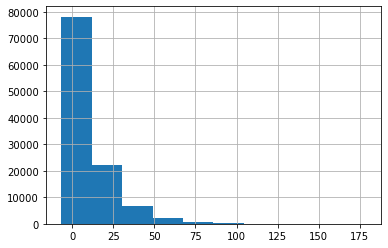

In [30]:
# let's get an idea of the distribution
df_new['time_passed'].hist(bins = 10);

this looks pretty good. Now I will group the data into four categories:
* **Super fast:** the patient got an appointment for the same day of scheduling
* **Fast:** the patient got an appointment in the next 7 days after scheduling (but not in the same day)
* **Moderate:** the patient got an appointment in the next 30 days after scheduling (but not in the next 7 days)
* **Slow:** the patient got an appointment after 30 days or more of scheduling

In [35]:
# create the categories
bin_edges = [0, 1, 7, 30, 179]

#give each bin a name
bin_names = ['Super fast', 'Fast', 'Moderate', 'Slow']

In [38]:
# create a new column with time categories
df_time['time_cat'] = pd.cut(df_time['time_passed'], bin_edges, labels=bin_names)
df_time.head(2)

,female,scheduledday,appointmentday,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,time_passed,time_cat
5,1,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,0,1,0,0,0,0,0,1.641076,Fast
6,1,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,23,0,0,0,0,0,0,1,1.371389,Fast


In [46]:
# group by no_show and get the counts for each
df_time_grouped = df_time.groupby(['time_cat', 'no_show'])['no_show'].count()
df_time_grouped

time_cat    no_show
Super fast  0           4100
            1           1113
Fast        0          20313
            1           6657
Moderate    0          20070
            1           9325
Slow        0           6953
            1           3424
Name: no_show, dtype: int64

In [ ]:
# let us create a plot of the results
df_time_grouped.plot(kind = 'bar')
plt.title('Relation between time of the appoint and no-shows')
plt.xlabel('')

* **Question 2:** Are males more likely to miss an appointment? and how do the age-group affect their behaviour? 
* **Question 3:** Are SMS a good way to decrease the no-shows?

In [ ]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!